# 💤 Drowsiness Detection — Optimized
Refactored and optimized notebook with fine-tuning, regularization,
callbacks, improved augmentation, and a live webcam demo.


## 📦 Imports and Environment Setup

In [ ]:
import os

import numpy as np

import tensorflow as tf
import multiprocessing

# Get number of CPU cores
num_cores = multiprocessing.cpu_count()

# Must be called before anything else in TF
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

print(f"Using {num_cores} CPU cores for TensorFlow")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# ✅ Now safe to import keras models etc.
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

tf.get_logger().setLevel('ERROR')

Using 12 CPU cores for TensorFlow


## 📂 Dataset Paths (update if needed)

In [6]:
# Update these paths if your dataset location differs
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
BASE_DIR =  os.path.join(parent_dir, "data")
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

CLASS_NAMES = ['closed', 'no_yawn', 'open', 'yawn']

print("Training directory ", TRAIN_DIR)
print("Validation/test directory ",TEST_DIR)

Training directory  H:\GitHub\ML_DriverDrowsinessDetection\data\train
Validation/test directory  H:\GitHub\ML_DriverDrowsinessDetection\data\test


## 🔄 Data Generators & Class Weights

In [ ]:
def create_generators(train_dir, test_dir, img_size=(224,224), batch_size=16, val_split=0.2):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.21,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8,1.2],
        channel_shift_range=10.0,     # NEW: color jitter
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=val_split
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='training', shuffle=True
    )

    val_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=True
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )

    # Compute class weights to handle imbalance
    from sklearn.utils.class_weight import compute_class_weight
    labels = train_gen.classes
    classes = np.unique(labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}

    return train_gen, val_gen, test_gen, class_weights_dict

# create generators (modify batch_size if needed)
train_gen, val_gen, test_gen, class_weights = create_generators(TRAIN_DIR, TEST_DIR, batch_size=32)
print('Class weights:', class_weights)


Found 1975 images belonging to 4 classes.
Found 492 images belonging to 4 classes.
Found 433 images belonging to 4 classes.
Class weights: {0: np.float64(0.9994939271255061), 1: np.float64(0.9994939271255061), 2: np.float64(1.0015212981744421), 3: np.float64(0.9994939271255061)}


## 🧠 Build & Compile Model (with L2 Regularization + Fine-tuning)

In [ ]:
def build_model(mode="single", num_classes=4, input_shape=(224,224,3), l2_reg=0.001, fine_tune_at=-10):
    """
    Flexible CNN Model Builder
    mode = "single" → Multi-class softmax (4 classes: open, closed, yawn, no_yawn)
    mode = "multi" → Multi-task binary heads (eye_state, yawn)
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    # Intermediate dense layer for added capacity
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)  # Reduced dropout from 0.7 to 0.4
    
    if mode == "single":
        # Multi-class classification
        output = Dense(num_classes, activation="softmax", kernel_regularizer=l2(l2_reg), name="class_output")(x)
        model = Model(inputs=base_model.input, outputs=output)
        
        # Label smoothing to reduce overconfidence
        loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
        
        model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
    
    elif mode == "multi":
        # Multi-task classification (2 outputs)
        eye_output = Dense(1, activation="sigmoid", name="eye_state")(x)
        yawn_output = Dense(1, activation="sigmoid", name="yawn")(x)
        model = Model(inputs=base_model.input, outputs=[eye_output, yawn_output])
        model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss={"eye_state": "binary_crossentropy", "yawn": "binary_crossentropy"},
            metrics={"eye_state": ["accuracy"], "yawn": ["accuracy"]}
        )
    # Freeze most layers, unfreeze only last N
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    return model

# Build model 
# Single-task (4-class softmax)
model = build_model(mode="single", num_classes=4)

# Multi-task (eye+yawn)
#model = build_model(mode="multi")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,268,228 (8.65 MB)

 Trainable params: 740,164 (2.82 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

## 🔧 Create a custom callback

In [9]:


class ValTestEarlyStopping(Callback):
    def __init__(self, test_data, patience=6, min_delta=1e-4, threshold=0.80, verbose=1):
        super().__init__()
        self.test_data = test_data
        self.patience = patience
        self.min_delta = min_delta
        self.threshold = threshold
        self.verbose = verbose
        self.best_score = -np.inf
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate on test data
        test_loss, test_acc = self.model.evaluate(self.test_data, verbose=0)
        val_acc = logs.get("val_accuracy")

        if self.verbose:
            print(f"\nEpoch {epoch+1}: val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

        # Condition: both >= threshold
        if val_acc >= self.threshold and test_acc >= self.threshold:
            current_score = (val_acc + test_acc) / 2.0  # combined metric (avg)

            if current_score - self.min_delta > self.best_score:
                # Improvement → save best weights
                self.best_score = current_score
                self.wait = 0
                self.best_weights = self.model.get_weights()
            else:
                # No improvement → increase patience counter
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    self.model.set_weights(self.best_weights)
                    if self.verbose:
                        print(f"\nEarly stopping at epoch {epoch+1} — both val_acc and test_acc ≥ {self.threshold*100:.0f}%")
        else:
            if self.verbose:
                print(f"↳ Accuracy below threshold {self.threshold*100:.0f}% — continue training.")

## 🚀 Train (with callbacks + checkpointing)

In [11]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # look at validation accuracy
    factor=0.5,               # reduce LR to given factor % of current value
    patience=3,               # wait for given epochs before reducing
    min_lr=1e-6,              # don’t go below this value
    verbose=1                 # print when LR is reduced
    )

# Custom early stopping (depends on both val & test accuracy)
early_stop = ValTestEarlyStopping(
    test_data=test_gen,   # your test generator/dataset
    patience=6,           # wait 6 epochs before reducing
    threshold=0.80,       # require ≥ 80%
    verbose=1             # print when accuracy below threshold 
    )

#  save only best model (highest validation accuracy)
checkpoint = ModelCheckpoint(
    'best_model.h5',        # file name
    save_best_only=True,    # save only best model 
    monitor='val_accuracy', # monitor validation accuracy value
    mode='max',             # maximize the monitored metric 
    verbose=1               # print the highest val. accuracy 
    )

# train the model
EPOCHS = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)


C:\Users\ranji\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5391 - loss: 1.5812
Epoch 1: val_acc=0.7927, test_acc=0.7806
↳ Accuracy below threshold 80% — continue training.

Epoch 1: val_accuracy improved from None to 0.79268, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6557 - loss: 1.0858 - val_accuracy: 0.7927 - val_loss: 0.4273 - learning_rate: 1.0000e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7837 - loss: 0.6886
Epoch 2: val_acc=0.7561, test_acc=0.8222
↳ Accuracy below threshold 80% — continue training.

Epoch 2: val_accuracy did not improve from 0.79268
62/62 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.7868 - loss: 0.6564 - val_accuracy: 0.7561 - val_loss: 0.4823 - learning_rate: 1.0000e-04
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8176 - loss: 0.5572
Epoch 3: val_acc=0.7419, test_acc=0.7852
↳ Accuracy below threshold 80% — continue training.

Epoch 3: val_accuracy did not improve from 0.79268
62/62 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8167 - loss: 0.5381 - val_accuracy: 0.7419 - val_loss: 0.7111 - learning_rate: 1.0000e-04
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8356 - loss: 0.4746
Epoch 4: ReduceLROnPlateau re

## 📊 Training Curves

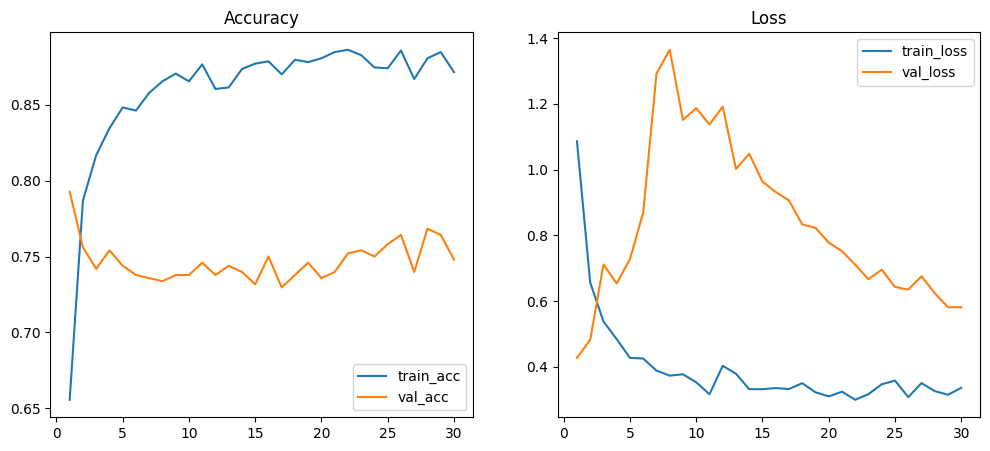

In [12]:
def plot_training(history):
    
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    # plot accuracy over epochs
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title('Accuracy')
    plt.legend()

    # plot loss over epochs
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_training(history)


## ✅ Load Best Model & Evaluate on Test Set

In [13]:
# Load best saved model if available
if os.path.exists('best_model.h5'):
    best = load_model('best_model.h5')
else:
    best = model

test_loss, test_acc = best.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 988ms/step - accuracy: 0.7806 - loss: 0.4924
Test accuracy: 0.7806, Test loss: 0.4924


## 🧾 Confusion Matrix & Classification Report

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
              precision    recall  f1-score   support

      Closed       1.00      0.79      0.88       109
        Open       0.83      1.00      0.90       109
     no_yawn       0.61      0.97      0.75       109
        yawn       0.93      0.35      0.51       106

    accuracy                           0.78       433
   macro avg       0.84      0.78      0.76       433
weighted avg       0.84      0.78      0.76       433



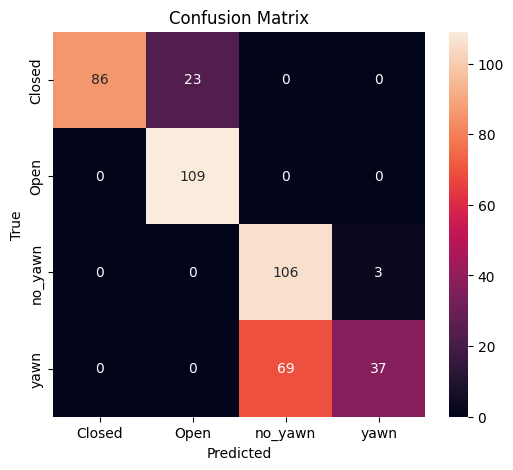

In [14]:

# Predict on test set
y_pred_probs = best.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 🎥 Live Webcam Demo (frame-by-frame + drowsiness scoring)

In [16]:
def live_webcam_prediction(model, class_names, img_size=(224,224), consecutive_frames_threshold=15):
    """Run live webcam feed and overlay predictions. If 'closed' or 'yawn' persists for
    `consecutive_frames_threshold` frames, an alert condition will be shown on screen."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print('Error: Could not open webcam.')
        return

    counter = 0
    last_alert = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(rgb, img_size)
        img = img.astype('float32') / 255.0
        inp = np.expand_dims(img, axis=0)

        preds = model.predict(inp, verbose=0)[0]
        idx = np.argmax(preds)
        label = class_names[idx]
        conf = preds[idx]

        # Increment counter for drowsiness conditions
        if label in ['closed', 'yawn'] and conf > 0.65:
            counter += 1
        else:
            counter = max(0, counter - 1)

        # Trigger alert if threshold crossed
        alert = counter >= consecutive_frames_threshold

        # Overlay UI
        text = f"{label} ({conf:.2f})"
        cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
        cv2.putText(frame, f'Frames: {counter}', (20,80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

        if alert:
            cv2.putText(frame, 'DROWSINESS ALERT!', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3)
            # Optional: play a sound or perform other actions here
            last_alert = True
        else:
            if last_alert:
                # briefly show recovered status
                cv2.putText(frame, 'RECOVERED', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)
                last_alert = False

        cv2.imshow('Drowsiness Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# To run the demo locally, uncomment below:
live_webcam_prediction(best, CLASS_NAMES)
